In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.base import clone
from pickle import dump
import xgboost as xgb


In [3]:
## Load the dataset
df = pd.read_csv('../data/dataset/dataset.csv')
df.head()

,1st_team,2nd_team,year,net_score,GK_height_cm_1st,GK_weight_kg_1st,GK_age_1st,GK_overall_1st,GK_potential_1st,GK_attacking_crossing_1st,...,RAM_mentality_vision_2nd,RAM_mentality_penalties_2nd,RAM_defending_marking_awareness_2nd,RAM_defending_standing_tackle_2nd,RAM_defending_sliding_tackle_2nd,RAM_goalkeeping_diving_2nd,RAM_goalkeeping_handling_2nd,RAM_goalkeeping_kicking_2nd,RAM_goalkeeping_positioning_2nd,RAM_goalkeeping_reflexes_2nd
0,Norway,Poland,2014,-3.0,192.0,78.0,23.0,72.0,75.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Australia,Ecuador,2014,-1.0,182.0,84.0,22.0,73.0,79.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Austria,Uruguay,2014,0.0,194.0,85.0,30.0,64.0,64.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Czech Republic,Norway,2014,0.0,196.0,90.0,32.0,85.0,85.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,England,Denmark,2014,1.0,196.0,91.0,27.0,82.0,83.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.tail()

,1st_team,2nd_team,year,net_score,GK_height_cm_1st,GK_weight_kg_1st,GK_age_1st,GK_overall_1st,GK_potential_1st,GK_attacking_crossing_1st,...,RAM_mentality_vision_2nd,RAM_mentality_penalties_2nd,RAM_defending_marking_awareness_2nd,RAM_defending_standing_tackle_2nd,RAM_defending_sliding_tackle_2nd,RAM_goalkeeping_diving_2nd,RAM_goalkeeping_handling_2nd,RAM_goalkeeping_kicking_2nd,RAM_goalkeeping_positioning_2nd,RAM_goalkeeping_reflexes_2nd
1116,Canada,Uruguay,2022,-2.0,195.0,84.0,34.0,75.0,75.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,Ecuador,Japan,2022,0.0,195.0,81.0,35.0,74.0,74.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,Iran,Senegal,2022,0.0,194.0,85.0,29.0,74.0,75.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1119,Saudi Arabia,United States,2022,0.0,185.0,79.0,30.0,71.0,71.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120,Portugal,Spain,2022,-1.0,190.0,84.0,34.0,82.0,82.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## Drop the columns that are not needed
df.drop("year", axis=1, inplace=True)

In [6]:
def class_maper(score):
    if score == 0:
        return 0  # Draw
    elif score > 0:
        return 1   # Home win
    elif score < 0:
        return 2   # Away Win
    

In [7]:
## Split the dataset into train and test
from sklearn.model_selection import train_test_split

X = df.drop('net_score', axis=1)
y = df['net_score'].apply(class_maper)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [8]:
le = preprocessing.LabelEncoder()

fifa2022_countries = pd.read_csv("../data/world_cup_2022_data/groups_of_2022.csv")["country"].values.tolist()
countries_set = set(list(X["2nd_team"]) + list(X["1st_team"]) + fifa2022_countries)

countries_encoder = le.fit(list(countries_set))
dump(countries_encoder, open('../models/encoders/countries_encoder.pkl', 'wb'))

X_train["2nd_team"] = countries_encoder.transform(X_train["2nd_team"])
X_train["1st_team"] = countries_encoder.transform(X_train["1st_team"])

X_test["2nd_team"] = countries_encoder.transform(X_test["2nd_team"])
X_test["1st_team"] = countries_encoder.transform(X_test["1st_team"])

In [12]:
## Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = PCA(n_components=0.9)
scaler = StandardScaler()



In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


estimators_dict = {
xgb.XGBClassifier():
{
    "est__n_estimators": [ 200, 500, 1500],
    "est__booster": ["gbtree", "gblinear"],
    "est__eta": [0.01, 0.1, 1.0],
    "est__alpha": [0, 0.5, 1],
    "est__lambda": [0, 1 , 2]

},
RandomForestClassifier():  
{
    "est__n_estimators": [10, 50, 100, 200, 500],
    "est__max_depth": [3, 5, 10, 20, 55],
    "est__min_samples_split": [2, 5, 10],
    "est__min_samples_leaf": [1, 2, 4],
    "est__bootstrap": [True, False],
    "est__criterion": ["gini", "entropy"]
},
AdaBoostClassifier():
{
    "est__n_estimators": [10, 50, 100, 200, 500],
    "est__learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "est__algorithm": ["SAMME", "SAMME.R"]
},
# GradientBoostingClassifier():
# {
#     "est__loss": ["log_loss", "exponential"],
#     "est__learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
#     "est__n_estimators": [10, 50, 100, 200, 500],
#     "est__max_depth": [3, 5, 10, 20, 50, 100, None],
#     "est__min_samples_split": [2, 5, 10],
#     "est__min_samples_leaf": [1, 2, 4],
#     "est__criterion": ["friedman_mse", "mse", "mae"]
# },
KNeighborsClassifier():
{
    "est__n_neighbors": [3, 5, 10, 20, 50, 100],
    "est__weights": ["uniform", "distance"],
    "est__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "est__leaf_size": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
},
# SVC():
# {
#     "est__C": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
#     "est__kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "est__degree": [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     "est__gamma": ["scale", "auto"],
#     "est__shrinking": [True, False]
# },
LogisticRegression():
{
    "est__penalty": ["l1", "l2"],
    "est__C": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
    "est__solver": ["newton-cg", "liblinear", "sag", "saga"],
    "est__max_iter": [100, 200, 500, 1000, 2000, 5000, 10000]
}


}


In [15]:
from sklearn.model_selection import GridSearchCV

def get_best_estimator(estimator, params, cv):
    grid = GridSearchCV(estimator, params, cv=cv, scoring="f1_micro", n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_


In [16]:
### Get tunned pipeline
from sklearn.model_selection import cross_validate, KFold

scorers = ["f1_micro"]
train_f1_micro = "train_f1_micro"
test_f1_micro = "test_f1_micro"

cv = KFold(n_splits=5, shuffle=True, random_state=42)

valid_results = pd.DataFrame(columns=["estimator", "params", "train_f1_micro", "test_f1_micro"])    

                                      
for est, params in estimators_dict.items():
    print("Getting best estimator for {}".format(est))
    pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('est', est)])
    tunned_estimator = get_best_estimator(pipeline, params, cv)

    
    scores = cross_validate(tunned_estimator, X_train, y_train, cv=cv, return_train_score=True, scoring=scorers, n_jobs=-1)
    valid_results = valid_results.append({
        "estimator": tunned_estimator,
        "params": tunned_estimator.get_params(),
        train_f1_micro: scores["train_f1_micro"].mean(),
        test_f1_micro: scores["test_f1_micro"].mean(),
    }, ignore_index=True)

valid_results

Getting best estimator for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for RandomForestClassifier()


/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for AdaBoostClassifier()


/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for KNeighborsClassifier()


/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for LogisticRegression()


/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

,estimator,params,train_f1_micro,test_f1_micro
0,"(StandardScaler(), PCA(n_components=0.9), XGBC...","{'memory': None, 'steps': [('scaler', Standard...",0.547795,0.494853
1,"(StandardScaler(), PCA(n_components=0.9), (Dec...","{'memory': None, 'steps': [('scaler', Standard...",0.673578,0.485384
2,"(StandardScaler(), PCA(n_components=0.9), (Dec...","{'memory': None, 'steps': [('scaler', Standard...",0.521273,0.503235
3,"(StandardScaler(), PCA(n_components=0.9), KNei...","{'memory': None, 'steps': [('scaler', Standard...",0.451423,0.448636
4,"(StandardScaler(), PCA(n_components=0.9), Logi...","{'memory': None, 'steps': [('scaler', Standard...",0.547536,0.502193


In [17]:
## get the highest test score
best_estimator = valid_results.loc[valid_results[test_f1_micro].idxmax()]["estimator"]
best_estimator

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('est',
                 AdaBoostClassifier(algorithm='SAMME', n_estimators=10))])

In [18]:
X["1st_team"] = countries_encoder.transform(X["1st_team"])
X["2nd_team"] = countries_encoder.transform(X["2nd_team"])


In [19]:
for model in valid_results["estimator"].values:
    model = clone(model)
    print(model)
    model.fit(X, y)
    dump(model, open("../models/classification/{}.pkl".format(model["est"].__class__.__name__), "wb"))
    


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('est',
                 XGBClassifier(alpha=0, base_score=0.5, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.01,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=-1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, lambda=1,
                               learning_rate=0.5, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
 

/Users/aalbustami/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
# Test clssifiers on test data

from sklearn.metrics import f1_score

test_results = pd.DataFrame(columns=["estimator", "params", "test_f1_micro"])

for model in valid_results["estimator"].values:
    model = clone(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_results = test_results.append({
        "estimator": model,
        "params": model.get_params(),
        "test_f1_micro": f1_score(y_test, y_pred, average="micro")
    }, ignore_index=True)

/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f6/c9bxgxqd72ndbxyxv7_8mcrh0000gp/T/ipykernel_88309/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = te

XGBClassifier


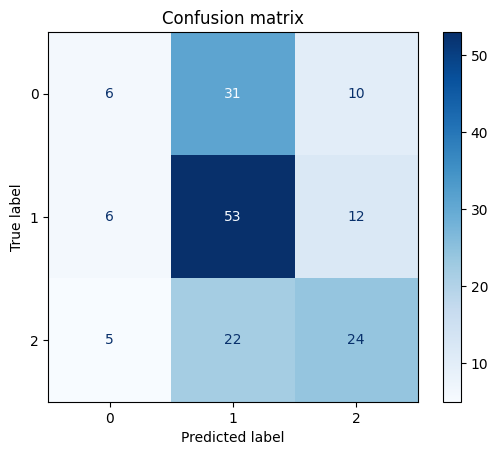

RandomForestClassifier


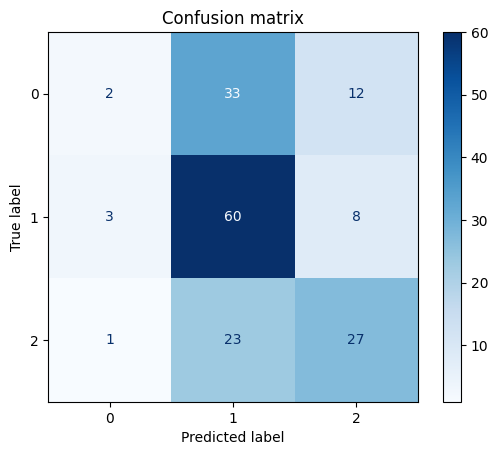

AdaBoostClassifier


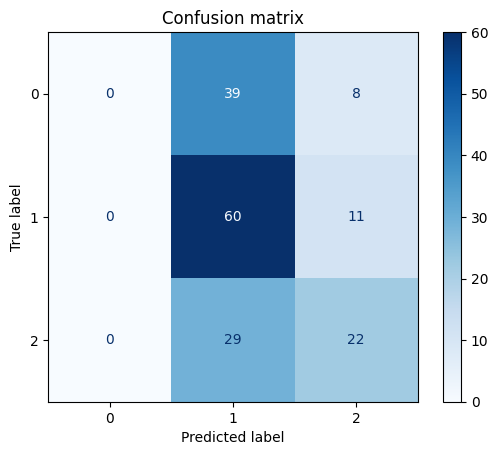

KNeighborsClassifier


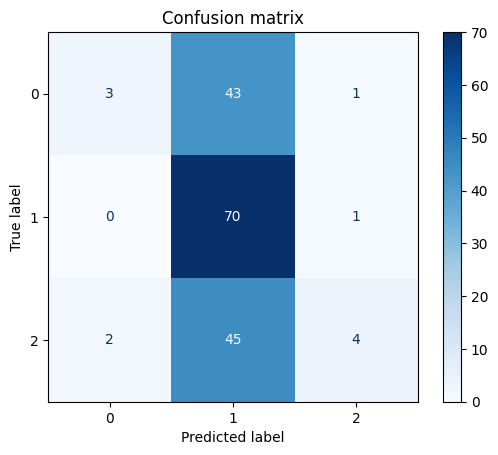

LogisticRegression


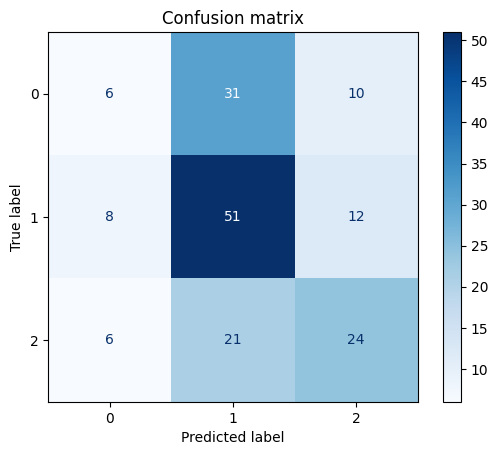

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
for model in valid_results["estimator"].values:
    print(model["est"].__class__.__name__)
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        # display_labels=class_names,
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title("Confusion matrix")
    plt.show()
    

    # print(disp.confusion_matrix)

